# 1. Import all packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
from pandas import ExcelWriter

%matplotlib inline

# 2. Define list of all organisms: name, UniProt ID, Data file, Type

In [2]:
organisms = [
                    ["Escherichia coli",         "up000000625", 
                     'uniprot-proteome_UP000000625.xlsx', "Prokaryote"],
    
                     ["Mycobacterium tuberculosis",  "UP000001584", 
                      'uniprot-proteome_UP000001584.xlsx', "Prokaryote"],
    
                     ["Bartonella henselae",  "UP000058422", 
                      'uniprot-proteome_UP000058422.xlsx', "Prokaryote"],
    
                     ["Schizosaccharomyces pombe", "UP000002485",
                     'uniprot-proteome_UP000002485.xlsx', "Fungi, unicellular"],
    
                     ["Saccharomyces cerevisiae", "up000002311",
                      'uniprot-proteome_UP000002311.xlsx', "Fungi, unicellular"],
    
                     ["Rattus norvegicus",  "UP000002494", 
                       'uniprot-proteome_UP000002494.xlsx', "Eukaryote"],
    
                     ["Mus musculus",             "up000000589", 
                     'uniprot-proteome_UP000000589.xlsx', "Eukaryote"],
    
                     ["Homo sapiens",             "up000005640", 
                     'uniprot-proteome_UP000005640.xlsx', "Eukaryote"],
            ]












# 3. Define protein composition nomenclature

In [3]:
oligomer_degree = [ 
                    ["Monomer",      1, "1-mer"], 
                    ["Homodimer",    2, "2-mer"],
                    ["Homotrimer",   3, "3-mer"],
                    ["Homotetramer", 4, "4-mer"],
                    ["Homopentamer", 5, "5-mer"],
                    ["Homohexamer",  6, "6-mer"],
                    ["Homoheptamer", 7, "7-mer"],
                    ["Homooctamer",  8, "8-mer"]
                  ]

# 4. Function that calculate frequency of homo-oligomers in proteome

In [4]:
def find_freq(df):
    df_freq = pd.DataFrame()    

    pro_count = np.zeros(len(oligomer_degree))
    cn_count  = np.zeros(len(oligomer_degree))

    for idx, degree in enumerate(oligomer_degree):
        
        df_o = df[df['Subunit structure [CC]'].str.contains(degree[0], case=False, na=False)]
        pro_count[idx] = len(df_o)
        cn_count[idx] = df_o['abundance'].sum()
        
    pro_number = sum(pro_count)    
    pro_freq = np.array([ pro_count / pro_number])
    
    cp_number = sum(cn_count)    
    pro_abun = np.array([ cn_count / cp_number])
    
    df_freq = pd.DataFrame()
    df_freq["type"] = [i[2] for i in oligomer_degree] 
    df_freq["subunits"] = [i[1] for i in oligomer_degree] 
    df_freq["count"] = pro_count.T
    df_freq["frequency"] = pro_freq.T
    df_freq["abundance"] = pro_abun.T
    df_freq['total_protein_number'] = df.shape[0]
    df_freq['known'] = np.sum(pro_count)
    
    #print(df_freq)

    return df_freq, np.sum(pro_count)

# 5. Function that save results to ecxel file

In [5]:
def save_excel(df_all, exl_file):
    writer = ExcelWriter(exl_file)
    df_all.to_excel(writer)
    writer.save()

# 6. Procedure that calculate homo-oligomers distribution over proteome for all organisms listed before

In [6]:
df_freq_proteome = pd.DataFrame() 
df_freq_proteome_ex = pd.DataFrame()  

from functools import partial, reduce  

for i,organim in enumerate(organisms):
    
    file_cross_ref = r'.\%s\uniprot-proteome_%s_cross_ref.xlsx' % (organim[0],organim[1])
    file_cn = r'.\%s\%s_cn_integrated.xlsx' % (organim[0],organim[1])
    
    df1 = pd.read_excel(file_cross_ref)
    df2 = pd.read_excel(file_cn)
    
    d = {1: df1, 2: df2} 
    my_reduce = partial(pd.merge, on='string_external_id', how='outer') 
    result = reduce(my_reduce, d.values())
    
    file_merge = r'.\%s\%s_cross_ref_cn_merge.xlsx' % (organim[0],organim[1])
    save_excel(result, file_merge)
    
    df_org,known = find_freq(pd.read_excel(file_merge))    
    df_org.drop('type',axis=1, inplace=True)
    df_org.drop('count',axis=1, inplace=True)
    df_org.drop('frequency',axis=1, inplace=True)
    
    df_org["organism"] = organim[0]
    df_freq_proteome = pd.concat([df_freq_proteome, df_org])
    df_freq_proteome_ex = pd.concat([df_freq_proteome_ex, 
                                     df_org.pivot_table("abundance", 'organism', 'subunits')])
    
save_excel(df_freq_proteome_ex, 'proteome_abundance.xlsx')
save_excel(df_freq_proteome, 'proteome_abundance_all.xlsx')

# 7. Line plot with medians homo-oligomers distribution over proteome

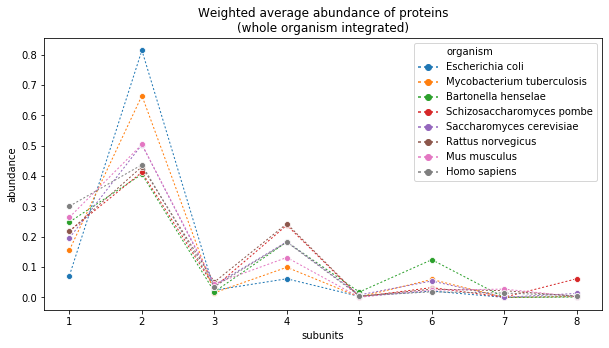

In [7]:
size=12
dash_styles = [(2,2) for x in range(size)] 
marker_styles = ['o' for x in range(size)] 

plt.figure(figsize=(10,5))
sns.lineplot(data=df_freq_proteome, x = "subunits", y = "abundance", 
             hue="organism", linewidth=1,
             style="organism", 
             markers=marker_styles, 
             dashes=dash_styles).set_title("Weighted average abundance of proteins\n(whole organism integrated)") 
plt.savefig('proteome_freq2_cp.png')

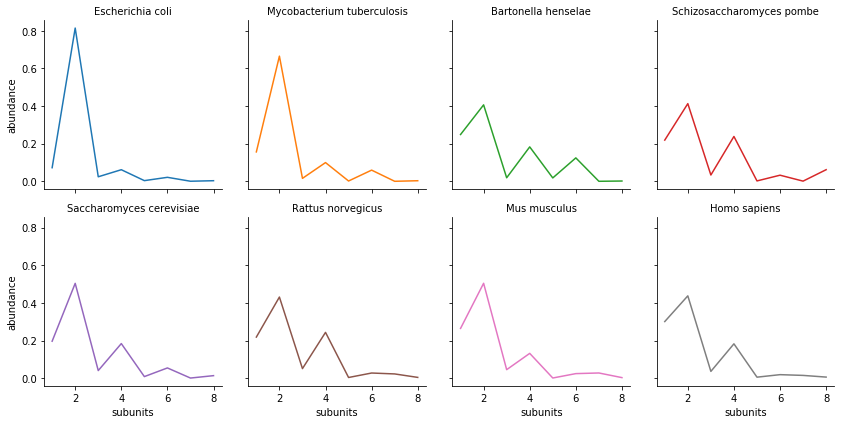

In [8]:
g = sns.FacetGrid(df_freq_proteome, col = 'organism', col_wrap=4, hue = 'organism', margin_titles=True)
g = g.map(plt.plot, 'subunits', "abundance")
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

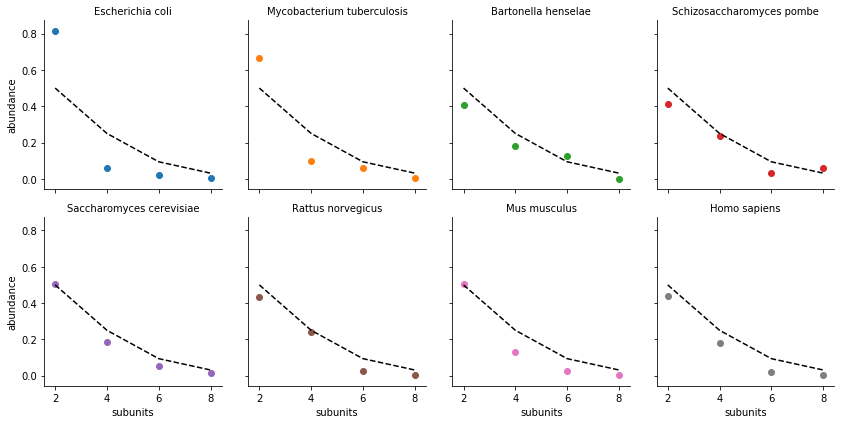

In [9]:
df_freq_proteome_even = df_freq_proteome[df_freq_proteome['subunits']%2 == 0]

g = sns.FacetGrid(df_freq_proteome_even, col = 'organism', col_wrap=4, hue = 'organism', margin_titles=True)
g = g.map(plt.scatter, 'subunits', "abundance")
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

subunits = [2, 4, 6, 8]
model = [2/2**2, 4/2**4, 6/2**6, 8/2**8]

for axs in g.axes:
    axs.plot(subunits, model, '--', c= 'black')
#     axs.text(6,0.6, "-- Model k\2^k")

plt.show()